# Word Vectors

Here, we explore several ways in which a word can be represented with an element of a vector space, i.e., a vector.

The first method is a co-ocurrence based one, and consists on the followings steps:

1. A text preprocessing instance, which may include tokenization, lemmatization, normalization, stemming and other ways to clean the text in order to reduce the vocabulary lenght and things like that.

2. The matrix desing process. This step determines the way we are going to represent our tokens: word by document, word by word, word by search proximity, adj. by modified noun, and many other ways to perform the count-based method can be proposed. This is the most determinant step in our model, because it defines how our tokens will be represented. Even if we choose to make a word by word count, this approach is mostly a feature based one, hence the importance of this step.

3. A reweighting process (probabilities, lenght norm, TF-IDF, PMI, Positive PMI, etc.)

4. An optional dimensionality reduction step (LSA, PLSA, LDA, PCA, NNMF, etc.)

5. Vector comparison is ruled by some distance measure (Euclidean, cosine, Dice, Jaccard, KL, etc.). Here, we measure how close related and non-related words are, and determine a way to evaluate our model results. 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
imdb20 = pd.read_csv('../data/vsmdata/imdb_window20-flat.csv.gz', index_col=0)

In [3]:
imdb20.head(10)

,!,);,.,..,...,:),?,abandoned,abdomen,abduct,...,zebra,zero,zinc,zombie,zombies,zone,zoo,,,´
!,3576432.0,1923.0,1439432.0,36608.0,227448.0,8077.0,288507.0,567.0,29.0,21.0,...,70.0,1797.0,2.0,4906.0,4072.0,882.0,249.0,9448.0,1397.0,5326.0
);,1923.0,28134.0,10958.0,42.0,629.0,6.0,1186.0,29.0,0.0,1.0,...,2.0,19.0,0.0,31.0,44.0,19.0,5.0,520.0,76.0,4.0
.,1439432.0,10958.0,41432784.0,106174.0,859122.0,18690.0,1181266.0,15758.0,301.0,535.0,...,738.0,19894.0,34.0,52947.0,39138.0,14227.0,3356.0,105786.0,25740.0,29782.0
..,36608.0,42.0,106174.0,197480.0,37752.0,958.0,18981.0,56.0,5.0,2.0,...,4.0,141.0,1.0,469.0,290.0,69.0,28.0,313.0,71.0,292.0
...,227448.0,629.0,859122.0,37752.0,1221120.0,3468.0,131959.0,433.0,15.0,15.0,...,26.0,880.0,4.0,2654.0,2127.0,546.0,118.0,756.0,340.0,2570.0
:),8077.0,6.0,18690.0,958.0,3468.0,19898.0,1634.0,4.0,0.0,0.0,...,0.0,11.0,0.0,30.0,29.0,6.0,3.0,17.0,2.0,44.0
?,288507.0,1186.0,1181266.0,18981.0,131959.0,1634.0,1808168.0,817.0,29.0,49.0,...,43.0,1313.0,2.0,3327.0,3361.0,803.0,224.0,6268.0,1257.0,2048.0
abandoned,567.0,29.0,15758.0,56.0,433.0,4.0,817.0,11211.0,1.0,0.0,...,4.0,7.0,0.0,64.0,112.0,13.0,10.0,101.0,34.0,6.0
abdomen,29.0,0.0,301.0,5.0,15.0,0.0,29.0,1.0,216.0,1.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0
abduct,21.0,1.0,535.0,2.0,15.0,0.0,49.0,0.0,1.0,389.0,...,0.0,0.0,0.0,1.0,5.0,2.0,0.0,5.0,1.0,0.0


In [8]:
vocab = list(imdb20.columns.values)
print(vocab[:10])
print(len(vocab))
print('good' in vocab, 'bad' in vocab, 'excellent' in vocab, 'terrible' in vocab)

['!', ');', '.', '..', '...', ':)', '?', 'abandoned', 'abdomen', 'abduct']
5000
True True True True


Inspecting vectors. We observe the coordinates "good" and "bad" of the words "excellent" and "terrible".

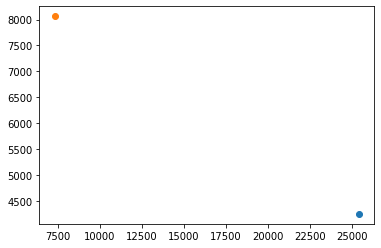

In [16]:
excellent_vec = np.array([imdb20['excellent']['good'], imdb20['excellent']['bad']])
terrible_vec = np.array([imdb20['terrible']['good'], imdb20['terrible']['bad']])

fig, ax = plt.subplots()
ax.scatter(excellent_vec[0],excellent_vec[1])
ax.scatter(terrible_vec[0],terrible_vec[1])

Frequency distribution. Take a look into the frequency distribution of every word

In [ ]:
fig, ax = plt.subplots()
ax.bars()

---

# Contextual Word Representations: A Contextual Introduction - Noah A. Smith

En todo lo que sigue, el paper considera que el texto a procesar puede ser considerado como una serie de **word tokens**, que son a su vez, ejemplos de **word types**. Es decir, un vocabulario se conforma por todos los types, y cuando aparecen en un corpus de texto, se llaman tokens. (Es como si fuera la clase y el objeto). Lo importante es que el texto se puede ver como una sucesión de elementos ya tokenizados, y cada uno de ellos tiene un significado.

El primer intento de representar a esos tokens como elemntos manipulables es a través de números enteros positivos, que representan índices en un vocabulario. Esta representación se considera **discreta** porque los elementos que representan a los types viven en un espacio discreto (es decir, no existe el índice $2.5$ ni el índice $\pi$).

Si bien parece tener limitaciones, con esta primera representación ya se puede proceder a hacer la mayor parte de las tareas de NLP. Por ejemplo, dado un review de películas puedo definir un algoritmo que clasifique al comentario como positivo si encuentro los índices correspondientes a los types "buena", "bueno", "excelente", "el padrino", "entretenida", "divertida", etc. y negativo si aparecen los índices de los types "malo", "malísima" "aburrida", etc. Este algoritmo presenta varias desventajas:

* Es probable que la mayor parte de los comentarios a clasificar no contengan ninguna de las palabras indicadoras mencionadas anteriormente.

* Es probable que aunque estas palabras aparezcan, el comentario en su totalidad no se condiga con el resultado del algoritmo. 

* El algoritmo no aprende, por lo que depende fuertemente del contexto en el que esté siendo utilizado.

* Los datos necesarios para programar el algoritmo no son de fácil acceso.

La idea que se contrapone con una representación discreta se conoce como **representación continua**, e implica que las representaciones de los diferentes types compartan características entre ellos. Por ejemplo, las palabras "buena" y "excelente" tienen un significado parecido porque comparten (al menos en el contexto de clasificación de comentarios), la misma opinión. Por eso, se necesita un modelo que tenga en cuenta esta idea de *compartir características* entre types. Otro ejemplo puede ser el hecho de que muchas palabras comparten características semánticas, como "buena", "bueno", "buenos", etc. y eso también debe estar considerado en el modelo.

De aquí, suerge la opción, entre otras, de representar a los types como elementos de un espacio vectorial, es decir, como vectores. Cada componente del vector representaría una característica, y las diferentes métricas definidas en ese espacio pueden ayudar a relacionar vectores entre sí. 

Notemos que la representación discreta es equivalente a esta representación cuando los vectores son *one-hot* en el índice del type. De todas formas, esta nueva representación permite una manipulación distinta de los elementos, y por lo tanto, más posibilidades. 

Las características se conocen como features y pueden obtenerse en forma automática, mediante un algoritmo de aprendizaje, o manualmente. Además, existen dos grandes formas de aprender la representación: la **denotacional** y la **distribucional**. La primera utiliza información previa, como diccionarios o redes de palabras, para obtener una representación del significado o de las características en general. Por otro lado, la distribucional utiliza la hipótesis distribucional: "el significado de una palabra puede ser deducida de su contexto", y es la más utilizada puesto que vivimos en la época de los datos.